In general we are trying to solve an overdetermined system of equations, $\text{A}\bf{x} = \bf{b}$.

 - Each row in the matrix $\text{A}$ is derived from ratios of redundant visiblities, such that the elements of $\text{A}$ are integers representing the antennas used in that ratio

 - the vector $\bf{b}$ contains the sum of the antenna cable delays for that visibility ratio

 - the solution $\bf{x}$ will provide the cable delay $\tau$ for each antenna

\begin{equation}
\begin{bmatrix} 
1 & -2 & 1 & 0 & 0 & 0 & 0 & \cdots& \cdots\\ 
1 & -1 & -1 & 1 & 0 & 0 & 0 & \cdots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots& \ddots\\ 
\end{bmatrix}
\begin{bmatrix} 
\tau_1 \\ \tau_2 \\ \tau_3 \\ \tau_4 \\ \tau_5 \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} =
\begin{bmatrix} 
134\text{ns} \\ 78\text{ns} \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} \rightarrow \text{A}\bf{x} = \bf{b}
\end{equation}

Each visibility ratio is proportional to a complex exponential
\begin{equation}
\frac{V_{i j}}{V_{k l}} \propto \exp{\bigg(-2\pi i \cdot(\tau_i - \tau_j - \tau_k + \tau_l)\bigg)}
\end{equation}

Where in the example the first and second rows of $\text{A}$ are made from these visibilities:
\begin{align}
\frac{V_{12}}{V_{23}} &\leadsto 1\tau_1 -2\tau_2  + 1\tau_3 \rightarrow A_1\\
\frac{V_{12}}{V_{34}} &\leadsto 1\tau_1 -1\tau_2  - 1\tau_3 + 1\tau_4 \rightarrow A_2\\
\end{align} 

***


In [1]:
import random
import numpy as np

import estdel

from estdel.nn.data_creation import data_manipulation as dm

Load (or generate) a list of redundant baselines and get their data

In [2]:
red_bls, gains, uvd = dm.load_relevant_data('zen_data/zen.2458098.58037.xx.HH.uv',
                                            'zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

In [3]:
_, _bl_dict = dm.get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys(),
                                                     training_load_path = 'data/training_redundant_baselines_dict_80.npz',
                                                     testing_load_path = 'data/testing_redundant_baselines_dict_80.npz')
_bl_data = dm.get_seps_data(_bl_dict, uvd)

In [4]:
_bl_data = _bl_data
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

In [5]:
_gains = gains
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

***

Get the unique antennas

In [85]:
unique_ants = []
for key in _bl_dict.keys():
    if len(_bl_dict[key]) >= 2:
        for sep in _bl_dict[key]:
            for ant in sep:
                if ant not in unique_ants:
                    unique_ants.append(ant)

In [86]:
unique_ants = sorted(unique_ants)

Assign each antenna a random delay in the range of -100ns to 100ns

In [112]:
generated_ant_delays = {ant : np.random.uniform(low = -0.0100, high = 0.0100) for ant in unique_ants}

Generate a list of abstracted visibility ratios from redundant baselines ( pairs of redundant separations)

In [113]:
num_V_ratios = 100
list_o_sep_pairs = []

for i in range(num_V_ratios):
    
    # Randomly select a redundant baseline
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    
    while len(_bl_dict[unique_baseline]) < 2:
        unique_baseline = random.sample(_bl_dict.keys(), 1)[0]

    # randomly select two sepearations from that baseline
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]
    
    list_o_sep_pairs.append(two_seps)

***
Construct Data

In [114]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [115]:
def get_target(two_seps, d):
    
    ants = flatten_list_o_tuples(two_seps)
    
    ratio_delay  = d[ants[0]]
    ratio_delay -= d[ants[1]]
    ratio_delay -= d[ants[2]]
    ratio_delay += d[ants[3]]
    
    return ratio_delay

In [116]:
inputs = []
targets = []
flatten_list_o_tuples = lambda x: np.array(list(sum(x, ())))

nu = np.arange(1024)
for i in range(num_V_ratios):
    

    two_seps = list_o_sep_pairs[i]       
    true_delay = get_target(two_seps, generated_ant_delays)
    v_ratio = _flatness(two_seps)*np.exp(-2j*np.pi*(nu*true_delay + np.random.uniform()))
    
    inputs.append(v_ratio)
 

In [117]:
freqs = np.linspace(0.100,0.200,1024)

In [118]:
channel_width_in_GHz = np.mean(np.diff(freqs))

In [119]:
def scale_delays_to_ns(delays, channel_width_in_GHz = np.mean(np.diff(np.linspace(0.100,0.200,1024)))):
    return delays / channel_width_in_GHz

In [120]:
# delays in nanoseconds
true_ant_delays = {ant :scale_delays_to_ns(generated_ant_delays[ant]) for ant in generated_ant_delays.keys()}

In [121]:
tester = estdel.DelaySolver(list_o_sep_pairs, inputs, conversion_fn='default',true_ant_delays=true_ant_delays)

In [122]:
true_b = tester.true_b()

In [123]:
pred_b = tester.v_ratio_row_predictions

In [124]:
# http://maxwell.ucsc.edu/~drip/133/ch4.pdf
red_chi2 = np.sum((pred_b - np.mean(pred_b))**2/np.std(pred_b)**2) / len(pred_b)

In [125]:
red_chi2

0.9999999999999997

In [126]:
import matplotlib.pyplot as plt

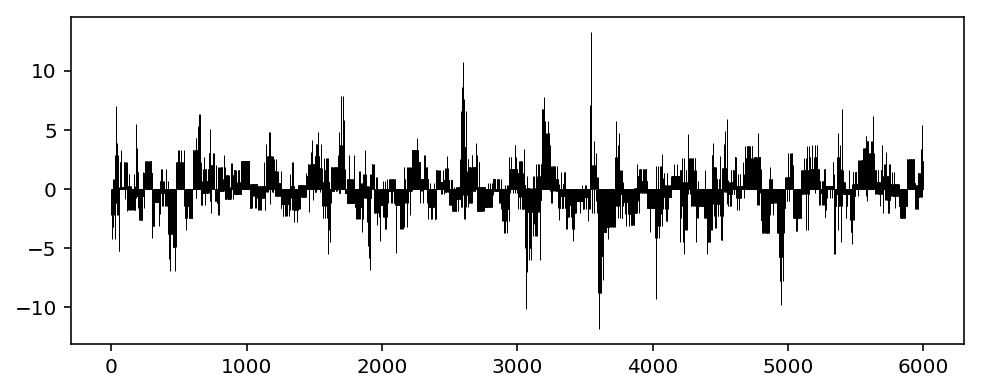

In [127]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.vlines(range(len(pred_b)), 0, true_b- pred_b, lw = 0.5)

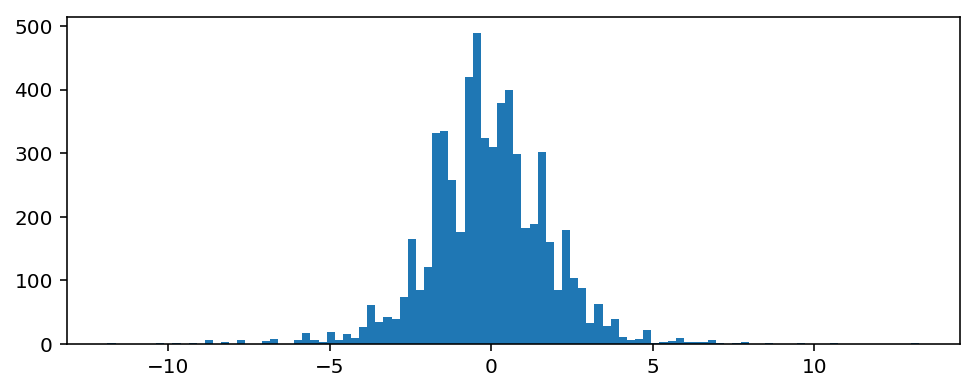

In [128]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.hist(true_b- pred_b, bins = 100);

In [129]:
np.std(np.abs(true_b- pred_b))

1.2278073677915466

In [130]:
A = tester.A

In [131]:
x_prediction_eval = np.linalg.lstsq(A[:, tester.unique_ants], pred_b, rcond = None)

In [132]:
x_prediction = x_prediction_eval[0]

In [133]:
x_prediction

array([ 47.35946556,  -3.33951262, 105.71282141, -21.21106886,
       -77.56926292,  80.87047745,  44.83935161,  27.92760892,
        22.732552  ,  15.67978496,  26.2057299 , -73.77743662,
        45.82555238, -27.84669619, -58.54118706, -16.43791271,
       -89.95886763, -16.43791271,  11.47748307,  90.82677107,
       -49.16172234,  79.63999388, -60.51257885,  -5.58285967,
        87.58825444, -77.08163734, -64.57029227, -56.21512702,
       -74.13407834, -92.16233928, -47.50777164, -86.02585574,
        84.47350736,  41.18740801,  45.8458003 , -82.53325799,
        20.69914303, -32.64160199,  52.4498068 ,  40.08336086,
       -63.02861618,  82.74575557,  29.41708207,  82.50069239,
       -25.02552206,  35.21471502])

In [134]:
predicted_antenna_delays = {tester.unique_ants[i]: x_prediction[i] for i in range(len(x_prediction))}
predicted_antenna_delays

{1: 47.35946556269076,
 11: -3.3395126169680225,
 12: 105.71282140752507,
 13: -21.21106886427649,
 14: -77.56926292218085,
 23: 80.87047745180328,
 24: 44.83935160510693,
 25: 27.927608920504227,
 26: 22.732551996996328,
 27: 15.679784956292139,
 36: 26.205729899253967,
 37: -73.77743662391693,
 38: 45.8255523778843,
 39: -27.846696194754216,
 40: -58.541187057829845,
 41: -16.437912709025255,
 51: -89.95886763121459,
 52: -16.43791270902531,
 53: 11.47748307160846,
 54: 90.82677106876721,
 55: -49.161722336648005,
 65: 79.63999387707821,
 66: -60.51257884948984,
 67: -5.582859673341218,
 68: 87.58825444292765,
 69: -77.08163734077728,
 70: -64.570292269948,
 71: -56.215127023157535,
 82: -74.1340783362489,
 83: -92.1623392824336,
 84: -47.50777163509722,
 86: -86.02585574124193,
 87: 84.47350735781126,
 88: 41.18740801252746,
 120: 45.845800295898655,
 121: -82.53325799406502,
 122: 20.699143029986587,
 123: -32.641601988339396,
 124: 52.44980679835618,
 137: 40.08336085595073,
 138:

In [145]:
error = {}
error_ls = []
for key in sorted(predicted_antenna_delays.keys()):
    print('{:3d}: {:6.2f}, {:6.2f}'.format(key,predicted_antenna_delays[key], scale_delays_to_ns(generated_ant_delays[key])))
    error[key] = scale_delays_to_ns(generated_ant_delays[key]) - predicted_antenna_delays[key]
    error_ls.append(error[key])

  1:  47.36,  39.33
 11:  -3.34,   0.40
 12: 105.71, 102.10
 13: -21.21, -31.61
 14: -77.57, -93.56
 23:  80.87,  87.70
 24:  44.84,  45.82
 25:  27.93,  22.17
 26:  22.73,  11.28
 27:  15.68,  -3.52
 36:  26.21,  39.13
 37: -73.78, -66.73
 38:  45.83,  46.60
 39: -27.85, -35.06
 40: -58.54, -70.49
 41: -16.44, -15.79
 51: -89.96, -76.04
 52: -16.44, -31.11
 53:  11.48,  10.71
 54:  90.83,  83.35
 55: -49.16, -63.48
 65:  79.64,  99.29
 66: -60.51, -44.36
 67:  -5.58,   4.72
 68:  87.59,  92.29
 69: -77.08, -79.11
 70: -64.57, -73.21
 71: -56.22, -71.88
 82: -74.13, -53.27
 83: -92.16, -77.39
 84: -47.51, -38.32
 86: -86.03, -89.48
 87:  84.47,  73.85
 88:  41.19,  25.08
120:  45.85,  59.97
121: -82.53, -73.44
122:  20.70,  21.72
123: -32.64, -39.02
124:  52.45,  40.26
137:  40.08,  70.20
138: -63.03, -39.42
139:  82.75,  98.88
140:  29.42,  40.46
141:  82.50,  86.35
142: -25.03, -26.81
143:  35.21,  27.36


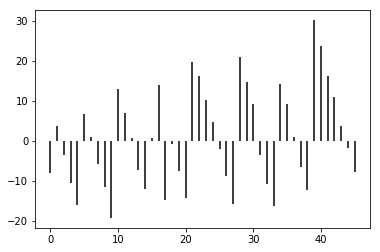

In [146]:
plt.vlines(range(len(error_ls)), 0, error_ls)